In [1]:
import sys
# sys.path.append("/mp-tl-study")

# from utils import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

In [3]:
# data_utils.py

import numpy as np
np.random.seed(42)

import torch
from torchvision import datasets, transforms

# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        
        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        
# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

In [4]:
# utils.py

import numpy as np
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import copy
# from data_utils import *

# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

def generate_fc_dnn_relu(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.ReLU()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model


# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if debug and batch_idx % 20 == 0:
            print('Train step: {} \tLoss: {:.6f}'.format(
                batch_idx, loss.item()))
        if (batch_idx == params['num_train']):
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            break

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    print("yo")
    
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model


# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, cut_point + 4):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]
        
        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])
        
    final_layer = nn.Linear(300,10)
    final_activation = nn.LogSoftmax(dim = 1)
    init_weights(final_layer, sw, sb)
    
    new_layers.extend([final_layer, final_activation])

    # Return new model
    return nn.Sequential(*new_layers)

In [5]:
batch_size = 256 # 'batch size for SGD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

depth = 100 # dept of the network
width = 300 # width of fully-connected layer

dataset = MNISTtrainer(batch_size)
params = dict(device=device,
                width=width, lr = 1e-3, num_train = 15,
                sb=0.05, depth= depth, sw=2)

model = generate_fc_dnn_relu(dataset.input_dim, dataset.output_dim,
                params).to(device)

pretrain_acc, pretrain_test_acc, pre_trained_model = compute_training_acc_epochs(model, dataset, params, debug=True)

cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 111401806.63it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73683512.06it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29103122.43it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13875111.99it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

yo
Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=300, bias=True)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=300, bias=True)
  (7): ReLU()
  (8): Linear(in_features=300, out_features=300, bias=True)
  (9): ReLU()
  (10): Linear(in_features=300, out_features=300, bias=True)
  (11): ReLU()
  (12): Linear(in_features=300, out_features=300, bias=True)
  (13): ReLU()
  (14): Linear(in_features=300, out_features=300, bias=True)
  (15): ReLU()
  (16): Linear(in_features=300, out_features=300, bias=True)
  (17): ReLU()
  (18): Linear(in_features=300, out_features=300, bias=True)
  (19): ReLU()
  (20): Linear(in_features=300, out_features=300, bias=True)
  (21): ReLU()
  (22): Linear(in_features=300, out_features=300, bias=True)
  (23): ReLU()
  (24)

In [8]:
params

{'device': device(type='cuda'),
 'width': 300,
 'lr': 0.001,
 'num_train': 15,
 'sb': 0.05,
 'depth': 100,
 'sw': 2,
 'batch_size': 256}

In [15]:
import pickle, json

model_pkl_filename = "mnist_to_fmnist.pkl"  

with open(model_pkl_filename, 'wb') as file:  
    pickle.dump(model, file)
    
torch.save(model.state_dict(), "original_model.pt")

params['batch_size'] = batch_size
del params['device']

json_path = "model_params.json"
with open(json_path, 'w') as f:
    json.dump(params, f, indent=2, ensure_ascii=False)

In [16]:
import json, os

model_path = "original_model.pt"
model_state_dict = torch.load(model_path)

with open(os.path.join("model_params.json"), "r") as f:
    params = json.load(f)

In [17]:
batch_size = 256
depth = 100
width = 300

fashion_dataset = FashionMNISTtrainer(batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params['device'] = 'cuda'

model = generate_fc_dnn_relu(dataset.input_dim, dataset.output_dim, params)
model.load_state_dict(model_state_dict)
model.to('cuda')
model.eval()

100%|██████████| 26421880/26421880 [00:01<00:00, 18707105.31it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295415.81it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5468955.56it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24315627.24it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=300, bias=True)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=300, bias=True)
  (7): ReLU()
  (8): Linear(in_features=300, out_features=300, bias=True)
  (9): ReLU()
  (10): Linear(in_features=300, out_features=300, bias=True)
  (11): ReLU()
  (12): Linear(in_features=300, out_features=300, bias=True)
  (13): ReLU()
  (14): Linear(in_features=300, out_features=300, bias=True)
  (15): ReLU()
  (16): Linear(in_features=300, out_features=300, bias=True)
  (17): ReLU()
  (18): Linear(in_features=300, out_features=300, bias=True)
  (19): ReLU()
  (20): Linear(in_features=300, out_features=300, bias=True)
  (21): ReLU()
  (22): Linear(in_features=300, out_features=300, bias=True)
  (23): ReLU()
  (24): Linear(in_features=300, out_features=300, bias=True)
  (25): ReLU()
  (26): Li

In [20]:
eval(model, device, dataset.train_loader, debug=False)

0.8976111111111111

In [21]:
params

{'width': 300,
 'lr': 0.001,
 'num_train': 15,
 'sb': 0.05,
 'depth': 100,
 'sw': 2,
 'batch_size': 256,
 'device': 'cuda'}

In [22]:
from tqdm import tqdm

fashion_dataset = FashionMNISTtrainer(batch_size)

cut_models = []

# epochs fro fine tuning
params['num_train'] = 10
params['early_stop_patience'] = False
params['device'] = 'cuda'
for cut in tqdm(range(0, depth, 10)):
    temp = {}
    temp['cut_model'] = cut_model(model, sw = params['sw'], sb = params['sb'], cut_point = cut, freeze=True)
    temp['cut_model'].to('cuda')
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], fashion_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)

  0%|          | 0/10 [00:00<?, ?it/s]

yo


 10%|█         | 1/10 [01:32<13:55, 92.82s/it]

yo


 20%|██        | 2/10 [03:07<12:32, 94.11s/it]

yo


 30%|███       | 3/10 [04:43<11:05, 95.02s/it]

yo


 40%|████      | 4/10 [06:22<09:38, 96.47s/it]

yo


 50%|█████     | 5/10 [08:02<08:07, 97.54s/it]

yo


 60%|██████    | 6/10 [09:42<06:33, 98.43s/it]

yo


 70%|███████   | 7/10 [11:23<04:58, 99.37s/it]

yo


 80%|████████  | 8/10 [13:06<03:20, 100.42s/it]

yo


 90%|█████████ | 9/10 [14:51<01:41, 101.98s/it]

yo


100%|██████████| 10/10 [16:37<00:00, 99.74s/it] 


In [23]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i*10}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.8318148148148148
Cut 10:
0.7065555555555556
Cut 20:
0.5991111111111111
Cut 30:
0.5343148148148148
Cut 40:
0.46214814814814814
Cut 50:
0.4396851851851852
Cut 60:
0.4121111111111111
Cut 70:
0.38307407407407407
Cut 80:
0.3897777777777778
Cut 90:
0.37346296296296294


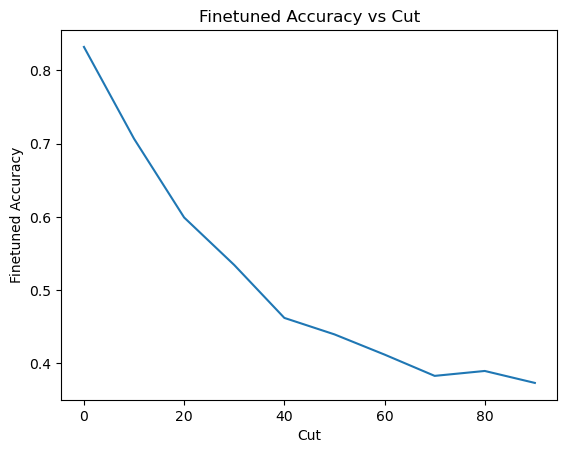

In [25]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(0,len(finetuned_accs)*10,10)
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

In [26]:
def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for i, layer in enumerate(linear_layers):
        layer.register_forward_hook(create_hook("linear_{}".format(i)))

    for i, layer in enumerate(activation_layers):
        layer.register_forward_hook(create_hook("relu_{}".format(i)))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape([images.shape[0], -1]).to(device)
            outputs = model(images)

    # Calculate and print variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = variance.mean().item()

    return result, variances

Layer linear_0 - Variance: 0.34339311718940735
Layer relu_0 - Variance: 0.14650759100914001
Layer linear_1 - Variance: 0.31266123056411743
Layer relu_1 - Variance: 0.13881999254226685
Layer linear_2 - Variance: 0.29637250304222107
Layer relu_2 - Variance: 0.1333741992712021
Layer linear_3 - Variance: 0.28285783529281616
Layer relu_3 - Variance: 0.13101878762245178
Layer linear_4 - Variance: 0.2715085446834564
Layer relu_4 - Variance: 0.1308087408542633
Layer linear_5 - Variance: 0.2925567328929901
Layer relu_5 - Variance: 0.12887327373027802
Layer linear_6 - Variance: 0.2952248752117157
Layer relu_6 - Variance: 0.13772720098495483
Layer linear_7 - Variance: 0.29806458950042725
Layer relu_7 - Variance: 0.12977008521556854
Layer linear_8 - Variance: 0.26282089948654175
Layer relu_8 - Variance: 0.1280236542224884
Layer linear_9 - Variance: 0.27825164794921875
Layer relu_9 - Variance: 0.14727552235126495
Layer linear_10 - Variance: 0.3213702142238617
Layer relu_10 - Variance: 0.16117538511

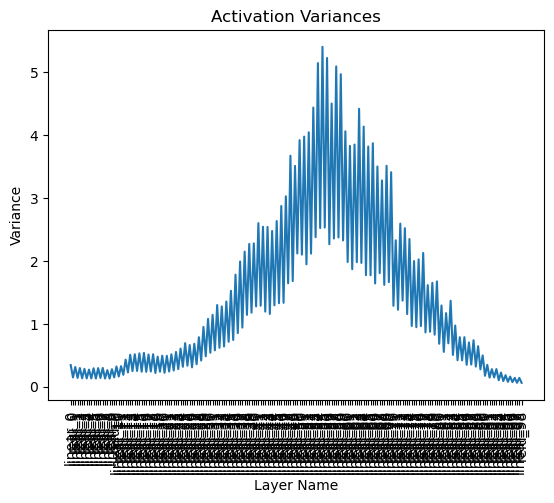

In [27]:
# Usage:
linear_layers = []
activation_layers = []
for i, layer in enumerate(model.modules()):
  if i % 2 == 1:
    linear_layers.append(layer)
  else:
    activation_layers.append(layer)
activation_layers = activation_layers[1:]

results, variances = compute_layer_variances(model, dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

Layer linear_0 - Variance: 0.3423624634742737
Layer relu_0 - Variance: 0.1471288800239563
Layer linear_1 - Variance: 0.306879460811615
Layer relu_1 - Variance: 0.13543060421943665
Layer linear_2 - Variance: 0.28101781010627747
Layer relu_2 - Variance: 0.1232554242014885
Layer linear_3 - Variance: 0.25978806614875793
Layer relu_3 - Variance: 0.12239997088909149
Layer linear_4 - Variance: 0.2606601119041443
Layer relu_4 - Variance: 0.12477999925613403
Layer linear_5 - Variance: 0.2782084345817566
Layer relu_5 - Variance: 0.12356141954660416
Layer linear_6 - Variance: 0.27549663186073303
Layer relu_6 - Variance: 0.12486648559570312
Layer linear_7 - Variance: 0.2725820541381836
Layer relu_7 - Variance: 0.12167341262102127
Layer linear_8 - Variance: 0.2531575560569763
Layer relu_8 - Variance: 0.12149950861930847
Layer linear_9 - Variance: 0.26271992921829224
Layer relu_9 - Variance: 0.13547122478485107
Layer linear_10 - Variance: 0.28354960680007935
Layer relu_10 - Variance: 0.1441072225570

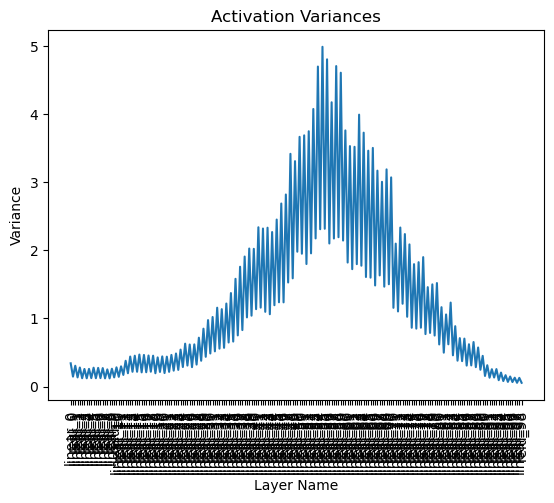

In [28]:
# Same on the train set:
results, variances = compute_layer_variances(model, dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


Layer linear_0 - Variance: 0.5295253396034241
Layer relu_0 - Variance: 0.20234434306621552
Layer linear_1 - Variance: 0.4088493585586548
Layer relu_1 - Variance: 0.16247528791427612
Layer linear_2 - Variance: 0.3405740559101105
Layer relu_2 - Variance: 0.135939821600914
Layer linear_3 - Variance: 0.27013099193573
Layer relu_3 - Variance: 0.12010352313518524
Layer linear_4 - Variance: 0.23036818206310272
Layer relu_4 - Variance: 0.0990525558590889
Layer linear_5 - Variance: 0.20505847036838531
Layer relu_5 - Variance: 0.08935341238975525
Layer linear_6 - Variance: 0.17935527861118317
Layer relu_6 - Variance: 0.0754932314157486
Layer linear_7 - Variance: 0.1546907275915146
Layer relu_7 - Variance: 0.06586117297410965
Layer linear_8 - Variance: 0.12759819626808167
Layer relu_8 - Variance: 0.05684031918644905
Layer linear_9 - Variance: 0.11805013567209244
Layer relu_9 - Variance: 0.059770599007606506
Layer linear_10 - Variance: 0.1184196025133133
Layer relu_10 - Variance: 0.057146538048982

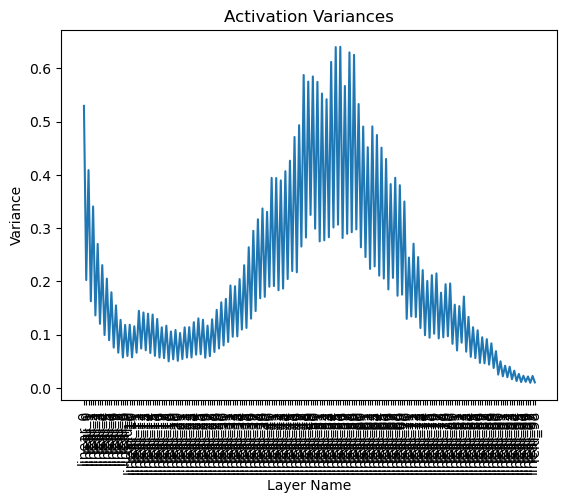

In [29]:
# on the fine-tuning dataset?
results, variances = compute_layer_variances(model, fashion_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

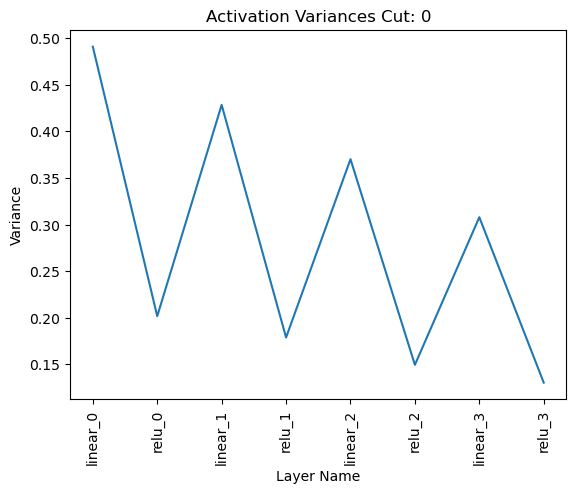

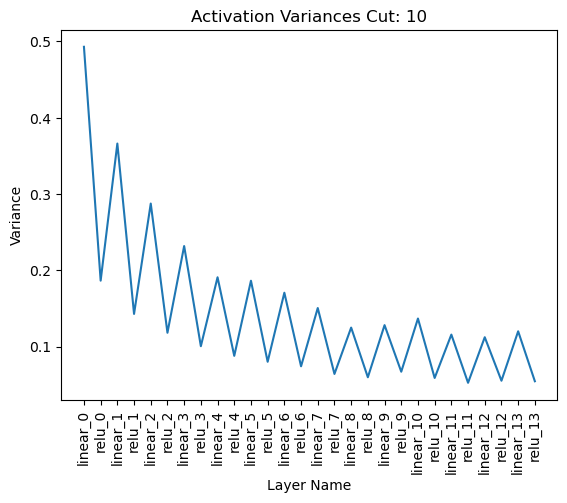

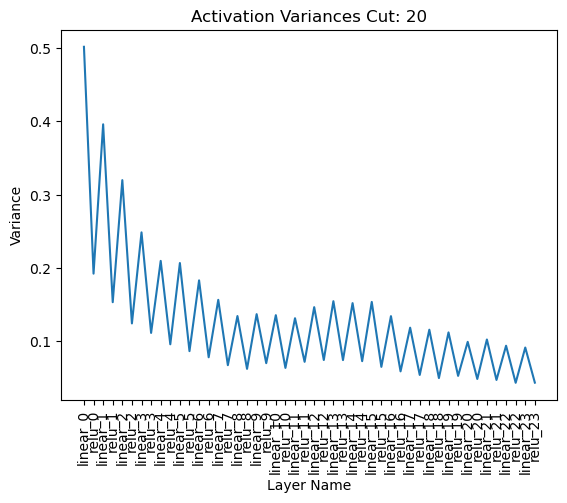

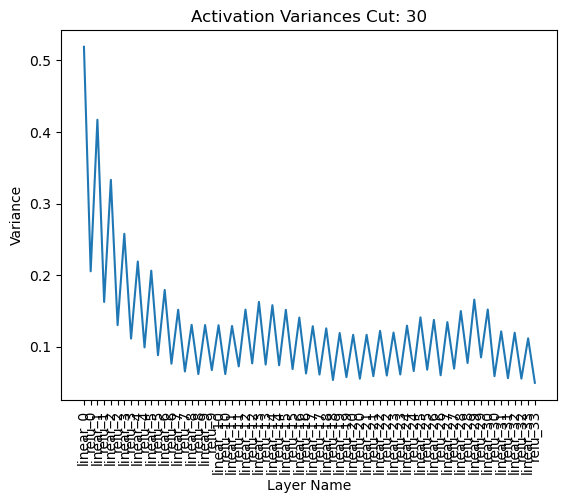

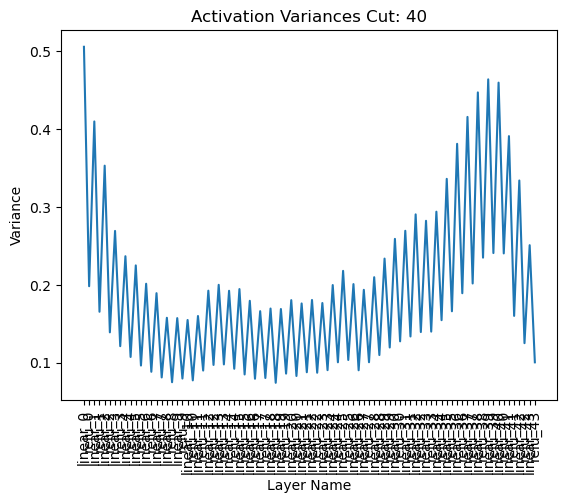

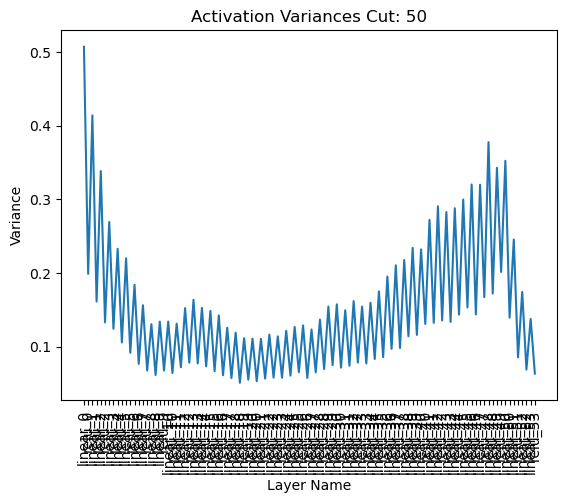

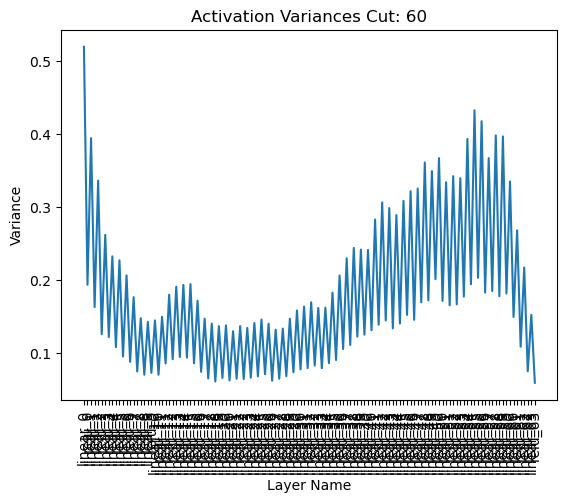

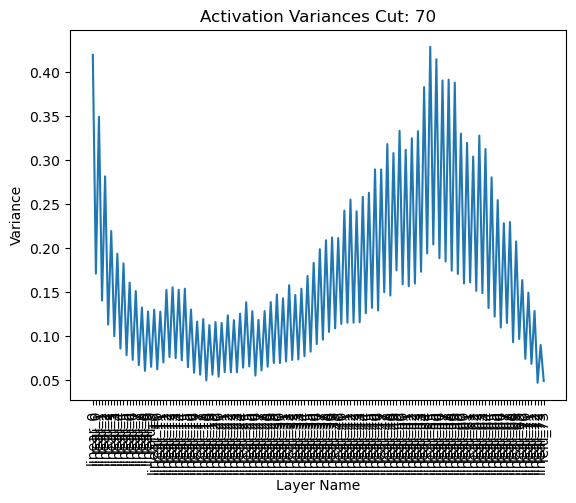

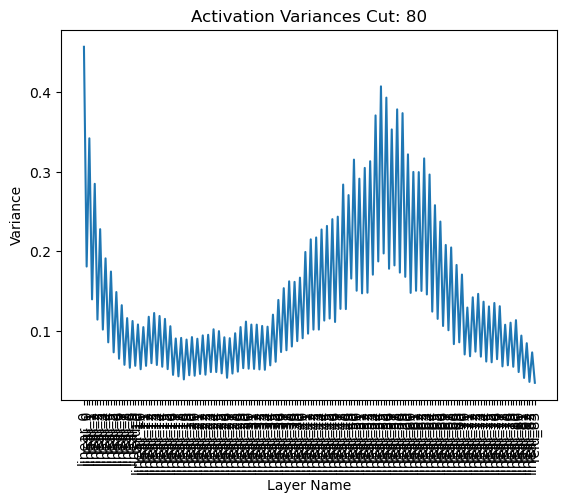

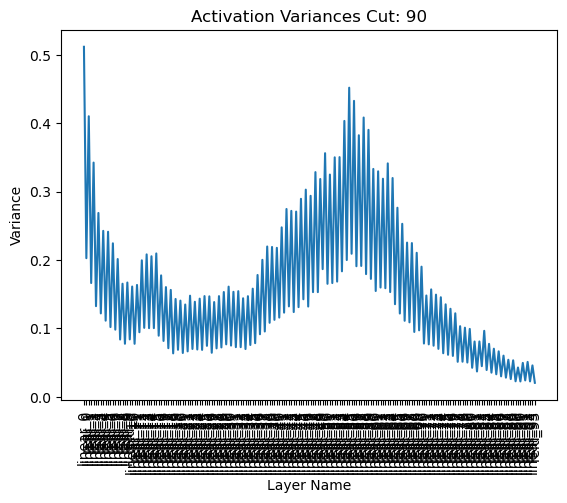

In [30]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], fashion_dataset.test_loader, device = 'cuda')
    
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()

In [31]:
from tqdm import tqdm

fashion_dataset = FashionMNISTtrainer(batch_size)

cut_models = []

# epochs fro fine tuning
params['num_train'] = 10
params['early_stop_patience'] = False
params['device'] = 'cuda'
for cut in tqdm(range(0, depth, 10)):
    temp = {}
    temp['cut_model'] = cut_model(model, sw = params['sw'], sb = params['sb'], cut_point = cut, freeze=False)
    temp['cut_model'].to('cuda')
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], fashion_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)

  0%|          | 0/10 [00:00<?, ?it/s]

yo


 10%|█         | 1/10 [01:35<14:19, 95.52s/it]

yo


 20%|██        | 2/10 [03:15<13:06, 98.27s/it]

yo


 30%|███       | 3/10 [05:01<11:50, 101.51s/it]

yo


 40%|████      | 4/10 [06:48<10:24, 104.02s/it]

yo


 50%|█████     | 5/10 [08:42<08:56, 107.31s/it]

yo


 60%|██████    | 6/10 [10:38<07:22, 110.56s/it]

yo


 70%|███████   | 7/10 [12:40<05:42, 114.03s/it]

yo


 80%|████████  | 8/10 [14:46<03:56, 118.06s/it]

yo


 90%|█████████ | 9/10 [16:56<02:01, 121.84s/it]

yo


100%|██████████| 10/10 [19:13<00:00, 115.36s/it]


In [39]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i*10}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.8308888888888889
Cut 10:
0.8413148148148148
Cut 20:
0.8425185185185186
Cut 30:
0.8383888888888889
Cut 40:
0.8136296296296296
Cut 50:
0.8228148148148148
Cut 60:
0.8202037037037037
Cut 70:
0.8078518518518518
Cut 80:
0.8058888888888889
Cut 90:
0.7968333333333333


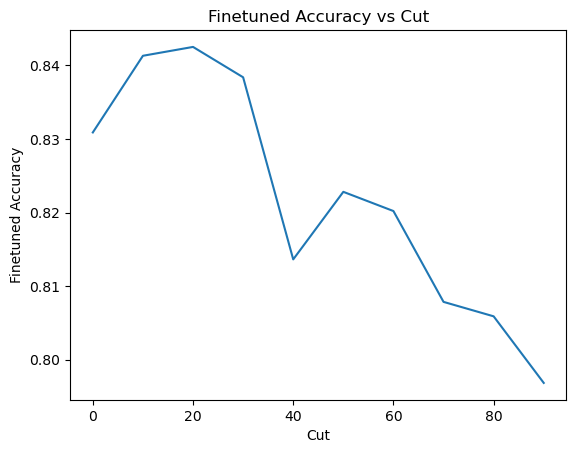

In [33]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(0,len(finetuned_accs)*10,10)
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

Layer linear_0 - Variance: 0.33662429451942444
Layer relu_0 - Variance: 0.14746737480163574
Layer linear_1 - Variance: 0.30634525418281555
Layer relu_1 - Variance: 0.1330723911523819
Layer linear_2 - Variance: 0.28323671221733093
Layer relu_2 - Variance: 0.1228272020816803
Layer linear_3 - Variance: 0.2583109140396118
Layer relu_3 - Variance: 0.1138203963637352
Layer linear_4 - Variance: 0.24801041185855865
Layer relu_4 - Variance: 0.11717002093791962
Layer linear_5 - Variance: 0.2562946677207947
Layer relu_5 - Variance: 0.11382847279310226
Layer linear_6 - Variance: 0.2550292909145355
Layer relu_6 - Variance: 0.12012425065040588
Layer linear_7 - Variance: 0.2639962434768677
Layer relu_7 - Variance: 0.11459454894065857
Layer linear_8 - Variance: 0.24960023164749146
Layer relu_8 - Variance: 0.12087924033403397
Layer linear_9 - Variance: 0.2685779631137848
Layer relu_9 - Variance: 0.14069609344005585
Layer linear_10 - Variance: 0.2860308587551117
Layer relu_10 - Variance: 0.1451169848442

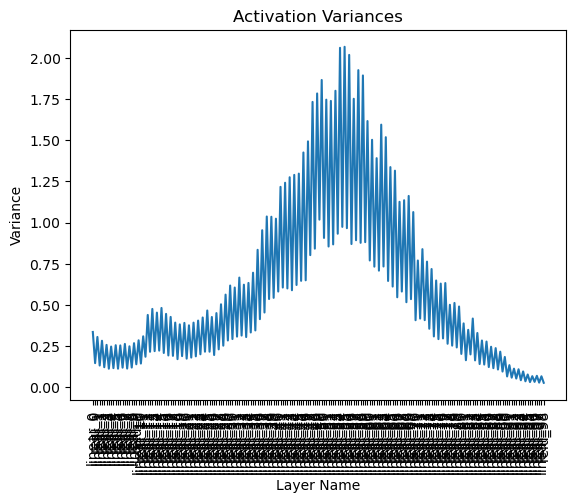

In [34]:
# Usage:
linear_layers = []
activation_layers = []
for i, layer in enumerate(model.modules()):
  if i % 2 == 1:
    linear_layers.append(layer)
  else:
    activation_layers.append(layer)
activation_layers = activation_layers[1:]

results, variances = compute_layer_variances(model, dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

Layer linear_0 - Variance: 0.3529425859451294
Layer relu_0 - Variance: 0.14999008178710938
Layer linear_1 - Variance: 0.3129422962665558
Layer relu_1 - Variance: 0.13750873506069183
Layer linear_2 - Variance: 0.28891119360923767
Layer relu_2 - Variance: 0.12508758902549744
Layer linear_3 - Variance: 0.26402124762535095
Layer relu_3 - Variance: 0.12364306300878525
Layer linear_4 - Variance: 0.26164981722831726
Layer relu_4 - Variance: 0.12430223077535629
Layer linear_5 - Variance: 0.2783181369304657
Layer relu_5 - Variance: 0.12410474568605423
Layer linear_6 - Variance: 0.276411235332489
Layer relu_6 - Variance: 0.12615104019641876
Layer linear_7 - Variance: 0.2753640115261078
Layer relu_7 - Variance: 0.12259387224912643
Layer linear_8 - Variance: 0.25512078404426575
Layer relu_8 - Variance: 0.12253241240978241
Layer linear_9 - Variance: 0.26637715101242065
Layer relu_9 - Variance: 0.1379726678133011
Layer linear_10 - Variance: 0.2888750731945038
Layer relu_10 - Variance: 0.146285593509

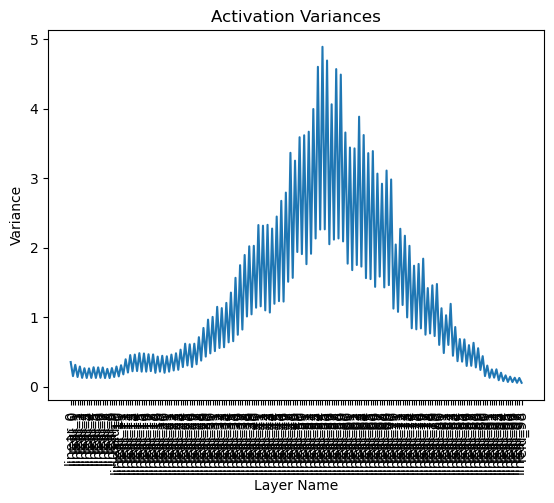

In [35]:
# Same on the train set:
results, variances = compute_layer_variances(model, dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

Layer linear_0 - Variance: 0.5238001346588135
Layer relu_0 - Variance: 0.1963929831981659
Layer linear_1 - Variance: 0.4080369174480438
Layer relu_1 - Variance: 0.16217392683029175
Layer linear_2 - Variance: 0.3308063745498657
Layer relu_2 - Variance: 0.13515983521938324
Layer linear_3 - Variance: 0.2707954943180084
Layer relu_3 - Variance: 0.12215930223464966
Layer linear_4 - Variance: 0.2352241575717926
Layer relu_4 - Variance: 0.10405219346284866
Layer linear_5 - Variance: 0.20841528475284576
Layer relu_5 - Variance: 0.08812890201807022
Layer linear_6 - Variance: 0.18050110340118408
Layer relu_6 - Variance: 0.07969266176223755
Layer linear_7 - Variance: 0.16329553723335266
Layer relu_7 - Variance: 0.07256536930799484
Layer linear_8 - Variance: 0.1393927037715912
Layer relu_8 - Variance: 0.0648847371339798
Layer linear_9 - Variance: 0.1414361298084259
Layer relu_9 - Variance: 0.07442785799503326
Layer linear_10 - Variance: 0.14554832875728607
Layer relu_10 - Variance: 0.0689395442605

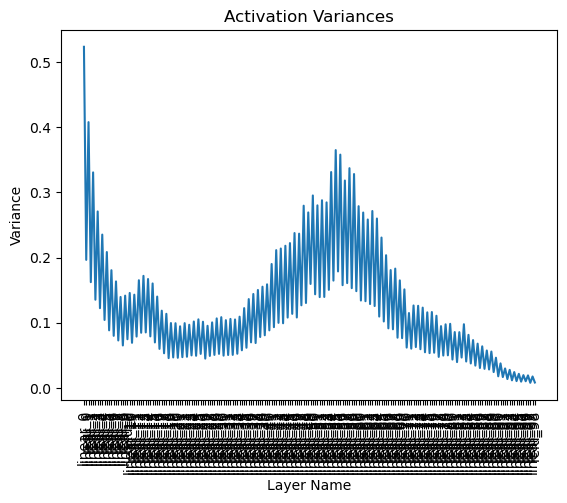

In [36]:
# on the fine-tuning dataset?
results, variances = compute_layer_variances(model, fashion_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

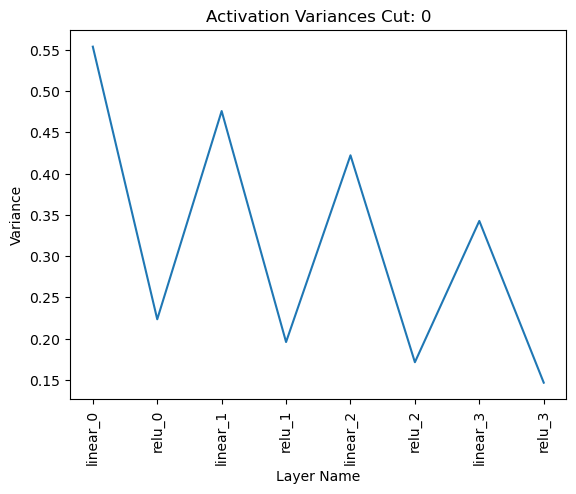

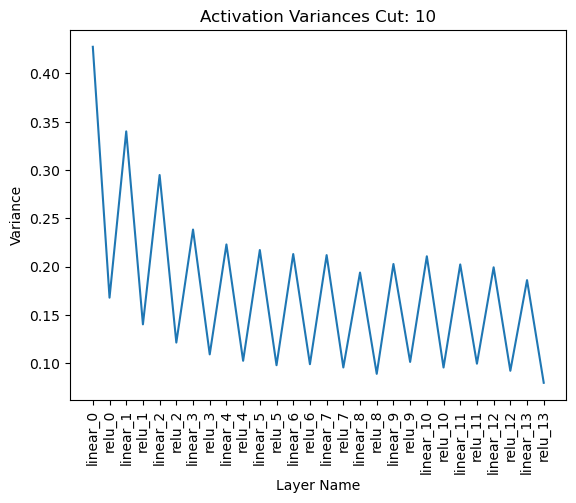

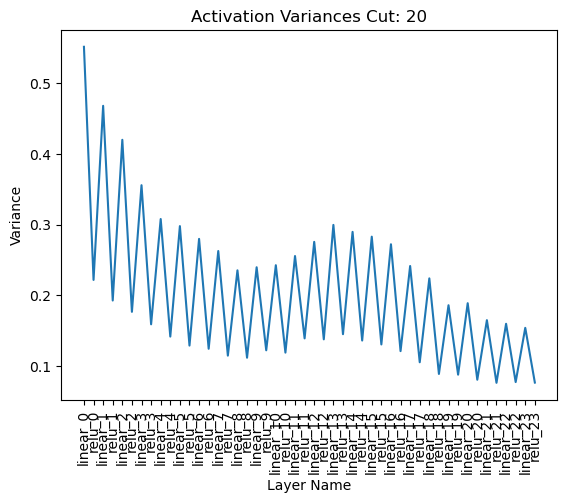

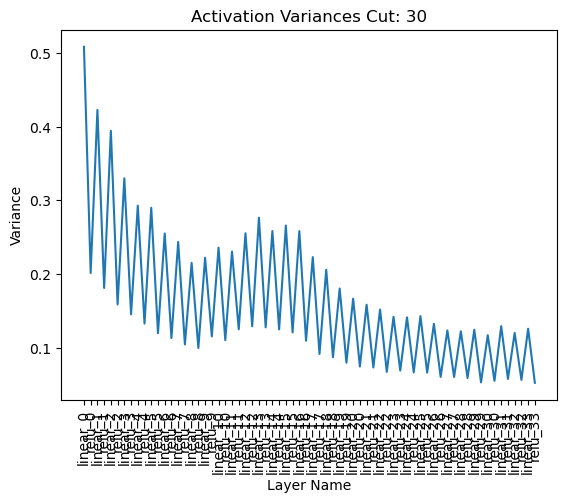

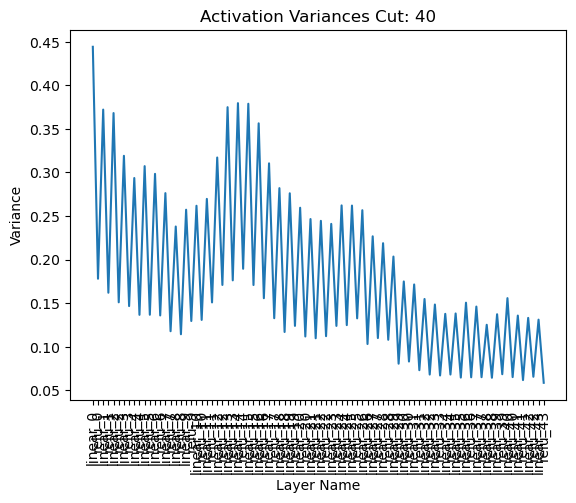

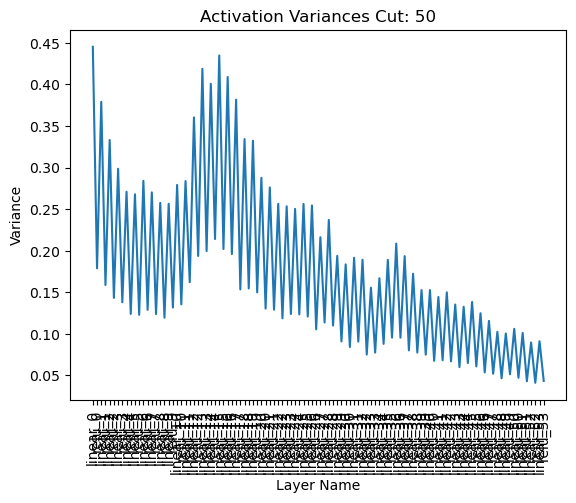

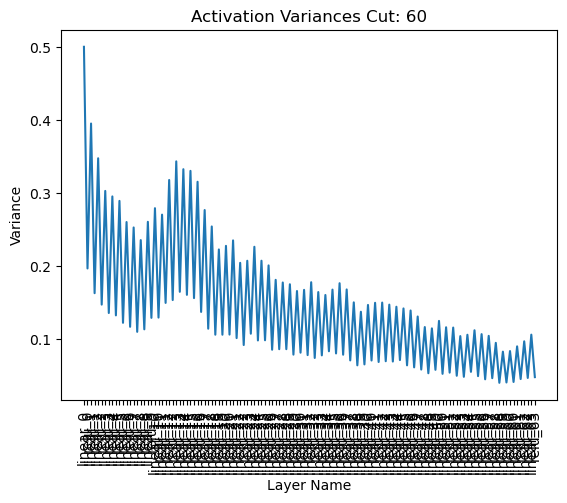

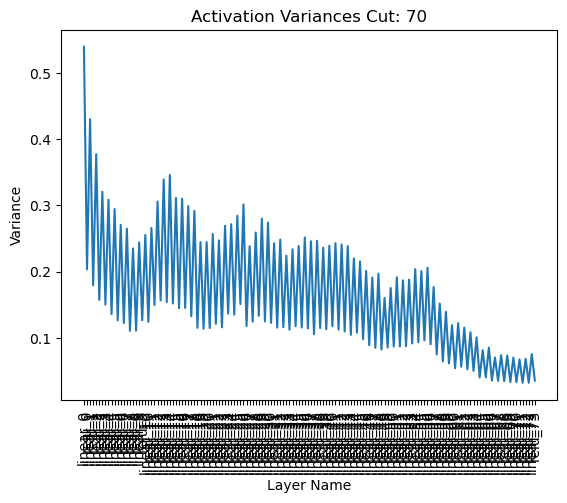

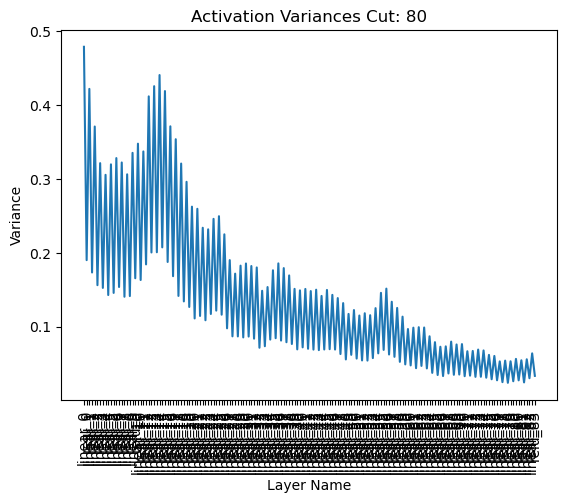

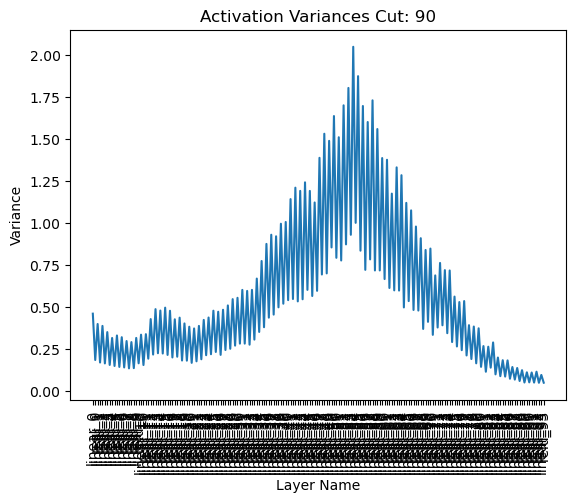

In [37]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], fashion_dataset.test_loader, device = 'cuda')
    
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()